<a href="https://colab.research.google.com/github/tomalexsmith/Cifair-Image-processing/blob/main/image_processing_cnn_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install requests

import requests

# I have uploaded the script speicified in the task brief to my own github
request = requests.get('https://raw.githubusercontent.com/tomalexsmith/ciFair-colab/main/cifair.py')

with open('cifair.py', 'w') as file:
  file.write(request.text)

import cifair

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from random import randint
from keras.utils import to_categorical
from sklearn import metrics
import seaborn as sns
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization,AvgPool2D
from keras import optimizers
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
import pandas as pd

## 1. Write code (must be well commented) to build a basic CNN architecture       

### Load the ciFAIR10 small images classification dataset using the provided data load script ‘cifair.py’ and the following code.



In [ ]:
def load_dataset():
  """
  Loads ciFair10 images, splitting them into training and testing data
  """
  (X_train, y_train), (X_test, y_test) = cifair.load_cifair10()

  return X_train, y_train, X_test, y_test

In [ ]:
def get_class_names():
  """
  Returns a list of all class labels from ciFair10
  """
  class_names = ['airplane', 'automobile', 'bird', 'cat',
                  'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
  return class_names

In [ ]:
X_train, y_train, X_test, y_test = load_dataset()

# verify shape of loaded dataset
print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


### Display  10  random  images  from  each  of  the  10  classes

In [ ]:
def show_images_10x10():
  """
  Displays a 10 by 10 grid of 10 random images, from each ciFair10 class
  """
  fig = plt.figure(figsize=(10,10))

  # iterate through rows and columns
  for row in range(10):
    for col in range(10):

      correct_cat = False
      while correct_cat == False:
        # choose a random image and check if it's of the correct class
        choice = randint(0,len(X_train))
        if get_class_names()[y_train.ravel()[choice]] == get_class_names()[col]:
          correct_cat = True
      fig.add_subplot(10, 10, 1+((10*row)+col))

      plt.xticks([])
      plt.yticks([])
      plt.imshow(X_train[choice])
      if row==9:
        plt.xlabel(get_class_names()[y_train.ravel()[choice]], rotation=45)

  plt.show()

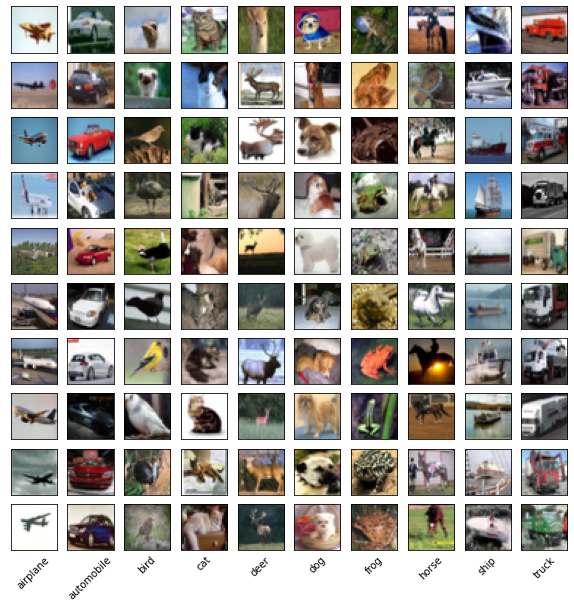

In [ ]:
show_images_10x10()

### Preprocess dataset for training and testing

In [ ]:
def preprocess_dataset(X_train, y_train, X_test, y_test, onehot=True):
  """
  Preprocesses data by normalising image pixels between 0 and 1, and one-hot
  encoding image labels
  """
  # one hot encode target values
  if onehot == True:
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

  # normalise to image pixels (0-1)
  X_train = X_train.astype('float32') / 255.0
  X_test = X_test.astype('float32') / 255.0

  return X_train, y_train, X_test, y_test

In [ ]:
def shuffle_and_batch(X_train, y_train, X_test, y_test, batch_size):
  """
  Shuffle and batch dataset
  """
  # combines image and label data in order to shuffle and batch them together
  X_y_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
  X_y_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))


  X_y_train = (X_y_train
                    .shuffle(buffer_size=len(X_train[0]))
                    .batch(batch_size=batch_size, drop_remainder=True))
  X_y_test = (X_y_test
                    .shuffle(buffer_size=len(X_train[0]))
                    .batch(batch_size=batch_size, drop_remainder=True))

  return X_y_train, X_y_test


### Define AlexNet CNN architecture

In [ ]:
def define_AlexNet(input_shape):
  """
  Defines a keras implementation of the standard AlexNet CNN architecture
  """
  AlexNet = keras.Sequential()

  # first convolutional layer
  AlexNet.add(Conv2D(filters=96, kernel_size=(11,11), strides=(4,4),
                     activation='relu', input_shape=input_shape))
  AlexNet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))

  # second convolutional layer
  AlexNet.add(Conv2D(filters=256, kernel_size=5, padding='same',
                     activation='relu'))
  AlexNet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))

  # third convolutional layer
  AlexNet.add(Conv2D(filters=384, kernel_size=3, padding='same',
                     activation='relu'))

  # fourth convolutional layer
  AlexNet.add(Conv2D(filters=384, kernel_size=3, padding='same',
                     activation='relu'))

  # fifth convolutional layer
  AlexNet.add(Conv2D(filters=256, kernel_size=3, padding='same',
                     activation='relu'))
  AlexNet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))

  AlexNet.add(Flatten())
  AlexNet.add(Dense(4096, activation='relu', input_shape=input_shape))
  AlexNet.add(Dropout(0.5))

  AlexNet.add(Dense(4096, activation='relu'))
  AlexNet.add(Dropout(0.5))

  AlexNet.add(Dense(10, activation='softmax'))

  return AlexNet

### Train model -> Report loss and accuracy

In [ ]:
# define model parameters
batch_size = 256
epochs = 15
input_shape = (32, 32, 3)

In [ ]:
# preprocess dataset by one-hot encoding labels and normalising image pixels
# between 0 and 1
X_train_proc, y_train_proc, X_test_proc, y_test_proc = preprocess_dataset(X_train, y_train, X_test, y_test)

# verify shape after preprocessing
print('Train: X=%s, y=%s' % (X_train_proc.shape, y_train_proc.shape))
print('Test: X=%s, y=%s' % (X_test_proc.shape, y_test_proc.shape))

# shuffle and batch dataset
X_y_train, X_y_test = shuffle_and_batch(X_train_proc, y_train_proc, X_test_proc, y_test_proc, batch_size)

Train: X=(50000, 32, 32, 3), y=(50000, 10)
Test: X=(10000, 32, 32, 3), y=(10000, 10)


In [ ]:
# create instance of AlexNet CNN
alex_net = define_AlexNet(input_shape)

In [ ]:
# compile and summarise CNN model
alex_net.compile(loss="categorical_crossentropy", optimizer="adam",
                metrics=["accuracy"])
alex_net.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 6, 6, 96)          34944     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 3, 3, 96)         0         
 g2D)                                                            
                                                                 
 conv2d_53 (Conv2D)          (None, 3, 3, 256)         614656    
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 2, 2, 256)        0         
 g2D)                                                            
                                                                 
 conv2d_54 (Conv2D)          (None, 2, 2, 384)         885120    
                                                                 
 conv2d_55 (Conv2D)          (None, 2, 2, 384)        

In [ ]:
# train AlexNet model
alex_history = alex_net.fit(X_y_train, epochs=epochs, batch_size=batch_size, validation_data=X_y_test)

Epoch 1/15
195/195 [==============================] - 6s 28ms/step - loss: 2.0478 - accuracy: 0.1893 - val_loss: 1.9190 - val_accuracy: 0.2422
Epoch 2/15
195/195 [==============================] - 6s 31ms/step - loss: 1.7903 - accuracy: 0.3033 - val_loss: 1.7424 - val_accuracy: 0.3563
Epoch 3/15
195/195 [==============================] - 5s 27ms/step - loss: 1.6343 - accuracy: 0.3893 - val_loss: 1.5577 - val_accuracy: 0.4340
Epoch 4/15
195/195 [==============================] - 6s 30ms/step - loss: 1.5442 - accuracy: 0.4317 - val_loss: 1.4920 - val_accuracy: 0.4579
Epoch 5/15
195/195 [==============================] - 6s 31ms/step - loss: 1.4672 - accuracy: 0.4633 - val_loss: 1.4872 - val_accuracy: 0.4617
Epoch 6/15
195/195 [==============================] - 6s 33ms/step - loss: 1.4227 - accuracy: 0.4820 - val_loss: 1.4482 - val_accuracy: 0.4843
Epoch 7/15
195/195 [==============================] - 5s 26ms/step - loss: 1.3900 - accuracy: 0.4983 - val_loss: 1.4530 - val_accuracy: 0.4848

In [ ]:
def plot_loss_accuracy(history, fig_title):
  """
  Plots two graphs to display the accuracy and loss of a given CNN model
  """
  loss_accuracy, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))
  epoch_ticks = np.arange(0, len(history.history['accuracy']), 1)
  epoch_labels = list()
  for label in range(len(epoch_ticks)):
    epoch_labels.append(str(label+1))

  plt.sca(ax1)
  ax1.plot(history.history['loss'],color='#4059AD',label='Training Loss',
           linewidth=3)
  ax1.plot(history.history['val_loss'],color='#F4B942',label='Validation Loss',
           linewidth=3)
  ax1.set_xlabel("")
  ax1.set_ylabel("Loss")
  plt.xticks(epoch_ticks, labels=epoch_labels)
  ax1.legend()
  ax1.set_title(fig_title, y=1.1, fontsize=16)

  plt.sca(ax2)
  ax2.plot(history.history['accuracy'],color='#4059AD',label='Training accuracy',
           linewidth=3)
  ax2.plot(history.history['val_accuracy'],color='#F4B942',
           label='Validation accuracy', linewidth=3)
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.xticks(epoch_ticks, labels=epoch_labels)
  ax2.legend()
  plt.show()

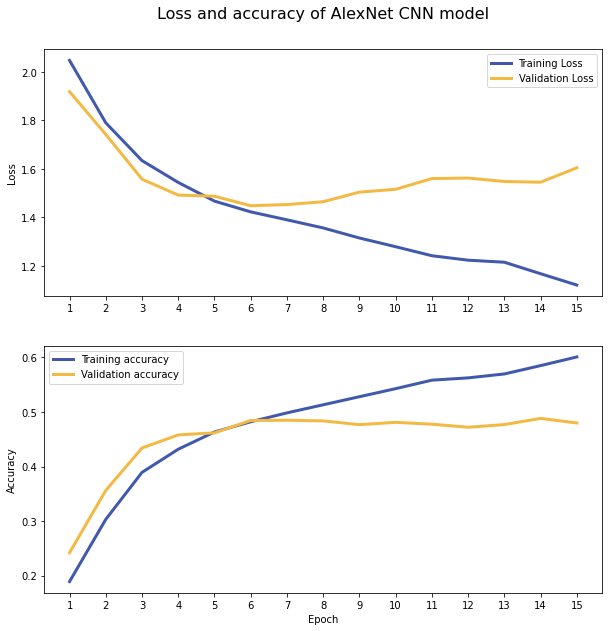

In [ ]:
plot_loss_accuracy(alex_history, 'Loss and accuracy of AlexNet CNN model')

### Predict single image

In [ ]:
def predict_single_image(image, cnn):
  """
  Uses a given CNN model to predict the label of a given image
  """
  image = np.expand_dims(image, axis=0)

  # normalise image pixels between 0 and 1
  image = image.astype('float32') / 255.0

  # predict image label
  prob_list = cnn.predict(image).ravel()

  # get the most likely label from the list of probailites
  pred = int(np.where(prob_list == prob_list.max())[0])
  pred_label = get_class_names()[pred]

  return pred_label

In [ ]:
def display_prediction(image, cnn, title):
  """
  Visualises the output of the 'predict_single_image' fuction
  """
  actual_label = get_class_names()[y_test.ravel()[index]]
  predicted_label = predict_single_image(selected_image, cnn)

  # colour text green if correct, and red if incorrect
  correct = 'INCORRECT'
  if actual_label == predicted_label:
    correct = 'CORRECT'

  # visualise label prediction
  plt.imshow(selected_image)
  plt.title(title)
  if correct == 'CORRECT':
    plt.gca().xaxis.label.set_color('tab:green')
  else:
    plt.gca().xaxis.label.set_color('tab:red')
  plt.xticks([])
  plt.yticks([])
  plt.xlabel("CNN predicted: {0}\nPrediction was {1}".format(predicted_label, correct), fontsize=12)
  print()

In [ ]:
# select an image from testing set to predict label for
index = randint(0,10000)
selected_image = X_test[index]

display_prediction(selected_image, alex_net, 'AlexNet CNN prediction')

## Custom CNN

In [ ]:
def define_improved_cnn(input_shape):
  """
  Defines an improved CNN architecture based off the orignal AlexNet
  architecture I previously implemented
  """
  improved_cnn = keras.Sequential()

  # first convolutional layer
  improved_cnn.add(Conv2D(filters=32, kernel_size=3, strides=1,
                          activation='relu', input_shape=input_shape))
  improved_cnn.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))
  improved_cnn.add(BatchNormalization())

  # second convolutional layer
  improved_cnn.add(Conv2D(filters=64, kernel_size=5, padding='same',
                          activation='relu'))
  improved_cnn.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))
  improved_cnn.add(BatchNormalization())

  # third convolutional layer
  improved_cnn.add(Conv2D(filters=128, kernel_size=3, padding='same',
                          activation='relu'))
  improved_cnn.add(BatchNormalization())

  # fourth convolutional layer
  improved_cnn.add(Conv2D(filters=256, kernel_size=3, padding='same',
                          activation='relu'))
  improved_cnn.add(BatchNormalization())

  # fifth convolutional layer
  improved_cnn.add(Conv2D(filters=128, kernel_size=3, padding='same',
                          activation='relu'))
  improved_cnn.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))
  improved_cnn.add(BatchNormalization())

  # sixth convolutional layer
  improved_cnn.add(Conv2D(filters=64, kernel_size=3, padding='same',
                          activation='relu'))
  improved_cnn.add(BatchNormalization())

  improved_cnn.add(Flatten())
  improved_cnn.add(Dense(256, activation='relu', input_shape=input_shape))
  improved_cnn.add(Dropout(0.5))
  improved_cnn.add(BatchNormalization())

  improved_cnn.add(Dense(256, activation='relu'))
  improved_cnn.add(Dropout(0.5))
  improved_cnn.add(BatchNormalization())

  improved_cnn.add(Dense(10, activation='softmax'))

  return improved_cnn

In [ ]:
# define model parameters
batch_size = 64
epochs = 20
initial_learning_rate = 1e-3
input_shape = (32,32,3)
loss_function = 'sparse_categorical_crossentropy'

In [ ]:
# preprocess dataset by normalising image pixels between 0 and 1
X_train_proc, y_train_proc, X_test_proc, y_test_proc = preprocess_dataset(X_train, y_train, X_test, y_test, False)

# verify shape after preprocessing
print('Train: X=%s, y=%s' % (X_train_proc.shape, y_train_proc.shape))
print('Test: X=%s, y=%s' % (X_test_proc.shape, y_test_proc.shape))

# shuffle and batch dataset
X_y_train, X_y_test = shuffle_and_batch(X_train_proc, y_train_proc, X_test_proc, y_test_proc, batch_size)

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


In [ ]:
# define model optimiser
optimiser=tf.optimizers.Adam(lr=initial_learning_rate)

# define learning rate decay algorithm
lr_decay = ReduceLROnPlateau(monitor='val_loss',
                             factor=0.1,
                             patience=3,
                             min_lr=1e-5)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# create instance of Improved CNN
my_cnn = define_improved_cnn(input_shape)

In [ ]:
# Compile and summarise CNN model
my_cnn.compile(loss=loss_function,
               optimizer=optimiser,
               metrics=['accuracy']
               )
my_cnn.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_57 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_16 (Bat  (None, 15, 15, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_58 (Conv2D)          (None, 15, 15, 64)        51264     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                      

In [ ]:
# train imrpoved cnn architecture
mycnn_history = my_cnn.fit(X_y_train,
                                 epochs=epochs,
                                 callbacks=[lr_decay],
                                 batch_size=batch_size,
                                 validation_data=X_y_test)

Epoch 1/20
781/781 [==============================] - 10s 10ms/step - loss: 1.5543 - accuracy: 0.4516 - val_loss: 1.2216 - val_accuracy: 0.5742 - lr: 0.0010
Epoch 2/20
781/781 [==============================] - 9s 11ms/step - loss: 0.9948 - accuracy: 0.6560 - val_loss: 0.9830 - val_accuracy: 0.6548 - lr: 0.0010
Epoch 3/20
781/781 [==============================] - 8s 11ms/step - loss: 0.8114 - accuracy: 0.7265 - val_loss: 0.8650 - val_accuracy: 0.7058 - lr: 0.0010
Epoch 4/20
781/781 [==============================] - 8s 11ms/step - loss: 0.6831 - accuracy: 0.7728 - val_loss: 0.9407 - val_accuracy: 0.6869 - lr: 0.0010
Epoch 5/20
781/781 [==============================] - 8s 10ms/step - loss: 0.5843 - accuracy: 0.8062 - val_loss: 0.8317 - val_accuracy: 0.7237 - lr: 0.0010
Epoch 6/20
781/781 [==============================] - 7s 9ms/step - loss: 0.4990 - accuracy: 0.8358 - val_loss: 1.0558 - val_accuracy: 0.6659 - lr: 0.0010
Epoch 7/20
781/781 [==============================] - 7s 9ms/ste

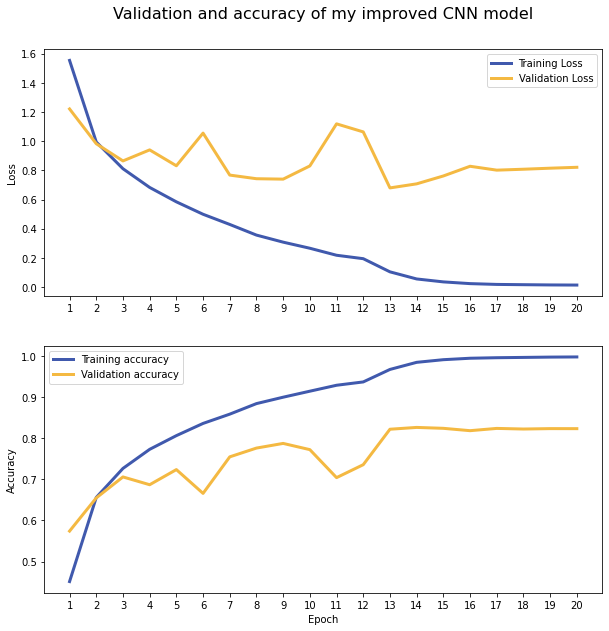

In [ ]:
plot_loss_accuracy(mycnn_history, 'Validation and accuracy of my improved CNN '
                            'model')

In [ ]:
def compare_alex_to_improved():
  """
  Plots four graphs to display the validation accuracy, training accuracy,
  validation loss and training loss of alexnet and my CNN model.
  """
  epoch_ticks = np.arange(0, len(mycnn_history.history['accuracy']), 1)
  epoch_labels = list()
  for label in range(len(epoch_ticks)):
    epoch_labels.append(str(label+1))


  comparison, axs = plt.subplots(2, 2, figsize=(18,12))

  # plot training loss comparison graph
  plt.sca(axs[0,0])
  axs[0,0].plot(mycnn_history.history['loss'],color='#4059AD',label='My CNN',
                linewidth=3)
  axs[0,0].plot(alex_history.history['loss'],color='#F4B942',label='AlexNet',
                linewidth=3)

  # change graph parameters
  plt.legend(frameon=False)
  plt.title('Training loss')
  plt.xticks(epoch_ticks, labels=epoch_labels, alpha=0.7)
  plt.yticks(alpha=0.7)
  plt.gca().spines["top"].set_alpha(0.0)
  plt.gca().spines["bottom"].set_alpha(0.3)
  plt.gca().spines["right"].set_alpha(0.0)
  plt.gca().spines["left"].set_alpha(0.3)
  plt.gca().grid(axis='both', alpha=.1, linewidth=.7, color='black',
                 linestyle='dashed')
  plt.gca().set_xlabel("Epoch", style='italic')
  plt.gca().set_ylabel("Training loss", style='italic')
  plt.gca().tick_params(axis="y", left=False)
  plt.gca().tick_params(axis="x", bottom=False)

  # plot validation loss comparison graph
  plt.sca(axs[0,1])
  axs[0,1].plot(mycnn_history.history['val_loss'],color='#4059AD',
                label='My CNN', linewidth=3)
  axs[0,1].plot(alex_history.history['val_loss'],color='#F4B942',
                label='AlexNet', linewidth=3)

  # change graph parameters
  plt.legend(frameon=False)
  plt.title('Validation loss')
  plt.xticks(epoch_ticks, labels=epoch_labels, alpha=0.7)
  plt.yticks(alpha=0.7)
  plt.gca().spines["top"].set_alpha(0.0)
  plt.gca().spines["bottom"].set_alpha(0.3)
  plt.gca().spines["right"].set_alpha(0.0)
  plt.gca().spines["left"].set_alpha(0.3)
  plt.gca().grid(axis='both', alpha=.1, linewidth=.7, color='black',
                 linestyle='dashed')
  plt.gca().set_ylabel("Validation loss", style='italic')
  plt.gca().set_xlabel("Epoch", style='italic')
  plt.gca().tick_params(axis="y", left=False)
  plt.gca().tick_params(axis="x", bottom=False)

  # plot training accuracy comparison graph
  plt.sca(axs[1,0])
  axs[1,0].plot(mycnn_history.history['accuracy'],color='#4059AD',
                label='My CNN', linewidth=3)
  axs[1,0].plot(alex_history.history['accuracy'],color='#F4B942',label='AlexNet',
                linewidth=3)

  # change graph parameters
  plt.legend(frameon=False)
  plt.title('Training accuracy')
  plt.xticks(epoch_ticks, labels=epoch_labels, alpha=0.7)
  plt.yticks(alpha=0.7)
  plt.gca().spines["top"].set_alpha(0.0)
  plt.gca().spines["bottom"].set_alpha(0.3)
  plt.gca().spines["right"].set_alpha(0.0)
  plt.gca().spines["left"].set_alpha(0.3)
  plt.gca().grid(axis='both', alpha=.1, linewidth=.7, color='black',
                 linestyle='dashed')
  plt.gca().set_ylabel("Training accuracy", style='italic')
  plt.gca().set_xlabel("Epoch", style='italic')
  plt.gca().tick_params(axis="y", left=False)
  plt.gca().tick_params(axis="x", bottom=False)

  # plot validation accuracy comparison graph
  plt.sca(axs[1,1])
  axs[1,1].plot(mycnn_history.history['val_accuracy'],color='#4059AD',
                label='My CNN', linewidth=3)
  axs[1,1].plot(alex_history.history['val_accuracy'],color='#F4B942',
                label='AlexNet', linewidth=3)

  # change graph parameters
  plt.legend(frameon=False)
  plt.title('Validation accuracy')
  plt.xticks(epoch_ticks, labels=epoch_labels, alpha=0.7)
  plt.yticks(alpha=0.7)
  plt.gca().spines["top"].set_alpha(0.0)
  plt.gca().spines["bottom"].set_alpha(0.3)
  plt.gca().spines["right"].set_alpha(0.0)
  plt.gca().spines["left"].set_alpha(0.3)
  plt.gca().grid(axis='both', alpha=.1, linewidth=.7, color='black',
                 linestyle='dashed')
  plt.gca().set_ylabel("Validation accuracy", style='italic')
  plt.gca().set_xlabel("Epoch", style='italic')
  plt.gca().tick_params(axis="y", left=False)
  plt.gca().tick_params(axis="x", bottom=False)


  comparison.suptitle("Comparison of performance between AlexNet CNN and my improved CNN", fontsize=20)


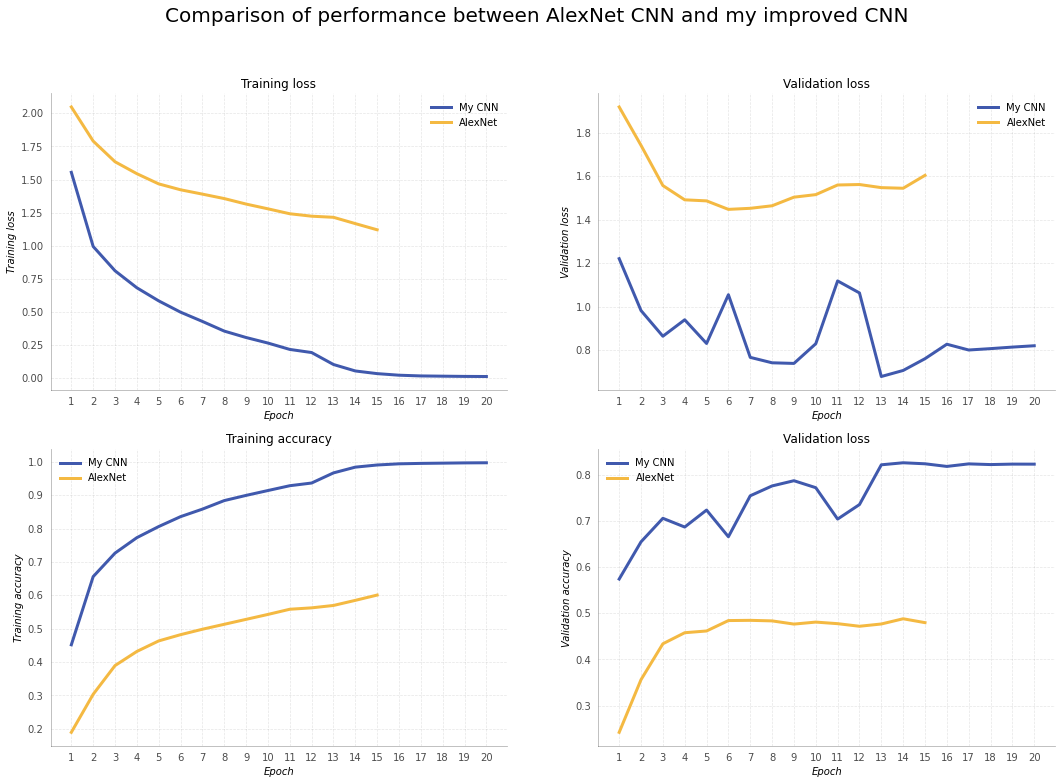

In [ ]:
compare_alex_to_improved()

### Predict single image

1/1 [==============================] - 0s 160ms/step



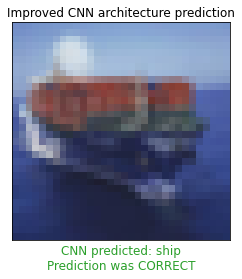

In [ ]:
# select an image from testing set to predict label
index = randint(0,10000)
selected_image = X_test[index]

display_prediction(selected_image, my_cnn, 'Improved CNN architecture prediction')

## Define LeNet and VGGNet CNN architechtures

### LeNet

In [ ]:
def define_LeNet(input_shape):

  Le_net = keras.Sequential()

  # first convolution layer
  Le_net.add(Conv2D(filters=6, kernel_size=5, activation='relu',
                    padding='same', input_shape=input_shape))
  Le_net.add(AvgPool2D(pool_size=2, strides=2))

  # second convolution layer
  Le_net.add(Conv2D(filters=16, kernel_size=5, activation='relu'))
  Le_net.add(AvgPool2D(pool_size=2, strides=2))

  Le_net.add(Flatten())
  Le_net.add(Dense(120, activation='sigmoid'))
  Le_net.add(Dense(84, activation='sigmoid'))
  Le_net.add(Dense(10, activation = 'softmax'))

  return Le_net

In [ ]:
# Define model parameters
batch_size = 256
epochs = 20
input_shape = (32,32,3)

In [ ]:
# preprocess dataset by one-hot encoding labels and normalising image pixels
# between 0 and 1
X_train_proc, y_train_proc, X_test_proc, y_test_proc = preprocess_dataset(X_train, y_train, X_test, y_test)

# Shuffle and batch dataset
X_y_train, X_y_test = shuffle_and_batch(X_train_proc, y_train_proc, X_test_proc, y_test_proc, batch_size)

In [ ]:
# create instance of leNet CNN
le_net = define_LeNet(input_shape)

In [ ]:
# compile and summarise CNN model
le_net.compile(loss='categorical_crossentropy',
                           optimizer='Adam',
                           metrics=['accuracy']
                           )
le_net.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 32, 32, 6)         456       
                                                                 
 average_pooling2d_2 (Averag  (None, 16, 16, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_38 (Conv2D)          (None, 12, 12, 16)        2416      
                                                                 
 average_pooling2d_3 (Averag  (None, 6, 6, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten_6 (Flatten)         (None, 576)               0         
                                                                 
 dense_18 (Dense)            (None, 120)              

In [ ]:
# train leNet model
lenet_history = le_net.fit(X_y_train, epochs=epochs, batch_size=batch_size, validation_data=X_y_test)

Epoch 1/20
195/195 [==============================] - 2s 7ms/step - loss: 2.0211 - accuracy: 0.2593 - val_loss: 1.7992 - val_accuracy: 0.3598
Epoch 2/20
195/195 [==============================] - 1s 6ms/step - loss: 1.6930 - accuracy: 0.3926 - val_loss: 1.5999 - val_accuracy: 0.4228
Epoch 3/20
195/195 [==============================] - 1s 6ms/step - loss: 1.5577 - accuracy: 0.4363 - val_loss: 1.5150 - val_accuracy: 0.4508
Epoch 4/20
195/195 [==============================] - 1s 6ms/step - loss: 1.4898 - accuracy: 0.4610 - val_loss: 1.4647 - val_accuracy: 0.4696
Epoch 5/20
195/195 [==============================] - 1s 6ms/step - loss: 1.4390 - accuracy: 0.4821 - val_loss: 1.4276 - val_accuracy: 0.4817
Epoch 6/20
195/195 [==============================] - 1s 6ms/step - loss: 1.3934 - accuracy: 0.5001 - val_loss: 1.3937 - val_accuracy: 0.4951
Epoch 7/20
195/195 [==============================] - 1s 6ms/step - loss: 1.3525 - accuracy: 0.5162 - val_loss: 1.3675 - val_accuracy: 0.5088
Epoch 

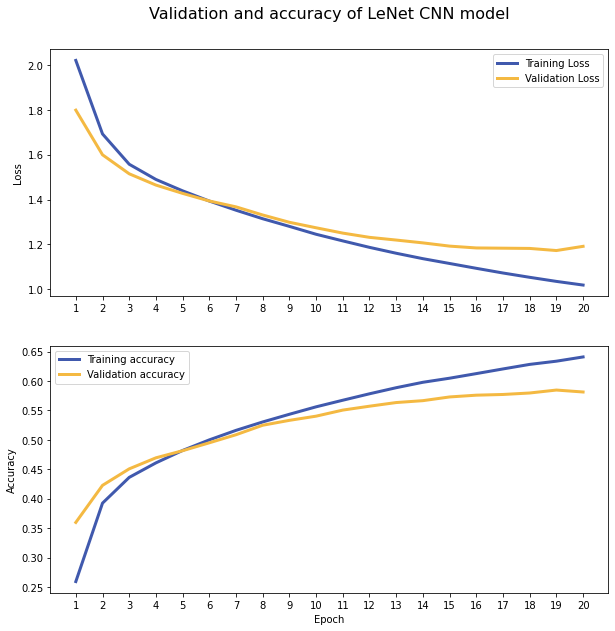

In [ ]:
plot_loss_accuracy(lenet_history, 'Validation and accuracy of LeNet CNN model')

### VGGNet

In [ ]:
def define_VGGNet(input_shape):

  VGG_net = keras.Sequential()

  # first set of convolution layers
  VGG_net.add(Conv2D(64, (3, 3), padding='same', activation='relu',
                     input_shape=input_shape))
  VGG_net.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
  VGG_net.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

  # second set of convolution layers
  VGG_net.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
  VGG_net.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
  VGG_net.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

  # third set of convolution layers
  VGG_net.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
  VGG_net.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
  VGG_net.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
  VGG_net.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

  # fourth set of convolution layers
  VGG_net.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
  VGG_net.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
  VGG_net.add( Conv2D(512, (3, 3), padding='same', activation='relu'))
  VGG_net.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

  # fifth set of convolution layers
  VGG_net.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
  VGG_net.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
  VGG_net.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
  VGG_net.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

  VGG_net.add(Flatten())
  VGG_net.add(Dense(units=4096,activation="relu"))
  VGG_net.add(Dense(units=4096,activation="relu"))
  VGG_net.add(Dense(units=10, activation="softmax"))

  return VGG_net

In [ ]:
# define VGGNet model parameters
batch_size = 256
epochs = 20
learning_rate = 1e-4
input_shape = (32,32,3)

In [ ]:
# preprocess dataset by one-hot encoding labels and normalising image pixels
# between 0 and 1
X_train_proc, y_train_proc, X_test_proc, y_test_proc = preprocess_dataset(X_train, y_train, X_test, y_test)

# shuffle and batch dataset
X_y_train, X_y_test = shuffle_and_batch(X_train_proc, y_train_proc, X_test_proc, y_test_proc, batch_size)

In [ ]:
# create instance of VGGNet CNN
VGG_net = define_VGGNet(input_shape)

In [ ]:
# compile and summarise CNN model
VGG_net.compile(loss='categorical_crossentropy',
                optimizer=tf.optimizers.Adam(lr=learning_rate),
                metrics=['accuracy']
                )
VGG_net.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 conv2d_40 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 conv2d_42 (Conv2D)          (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                 

In [ ]:
# train VGGNet model
vggnet_history = VGG_net.fit(X_y_train, epochs=epochs, batch_size=batch_size, validation_data=X_y_test)

Epoch 1/20
195/195 [==============================] - 22s 110ms/step - loss: 1.9878 - accuracy: 0.2153 - val_loss: 1.8367 - val_accuracy: 0.2848
Epoch 2/20
195/195 [==============================] - 21s 108ms/step - loss: 1.6064 - accuracy: 0.3702 - val_loss: 1.5116 - val_accuracy: 0.4190
Epoch 3/20
195/195 [==============================] - 21s 110ms/step - loss: 1.4080 - accuracy: 0.4688 - val_loss: 1.3309 - val_accuracy: 0.5066
Epoch 4/20
195/195 [==============================] - 21s 108ms/step - loss: 1.2365 - accuracy: 0.5422 - val_loss: 1.1876 - val_accuracy: 0.5626
Epoch 5/20
195/195 [==============================] - 21s 109ms/step - loss: 1.0934 - accuracy: 0.5993 - val_loss: 1.1469 - val_accuracy: 0.5876
Epoch 6/20
195/195 [==============================] - 21s 109ms/step - loss: 0.9715 - accuracy: 0.6496 - val_loss: 1.1583 - val_accuracy: 0.6018
Epoch 7/20
195/195 [==============================] - 23s 116ms/step - loss: 0.8539 - accuracy: 0.6963 - val_loss: 1.1017 - val_ac

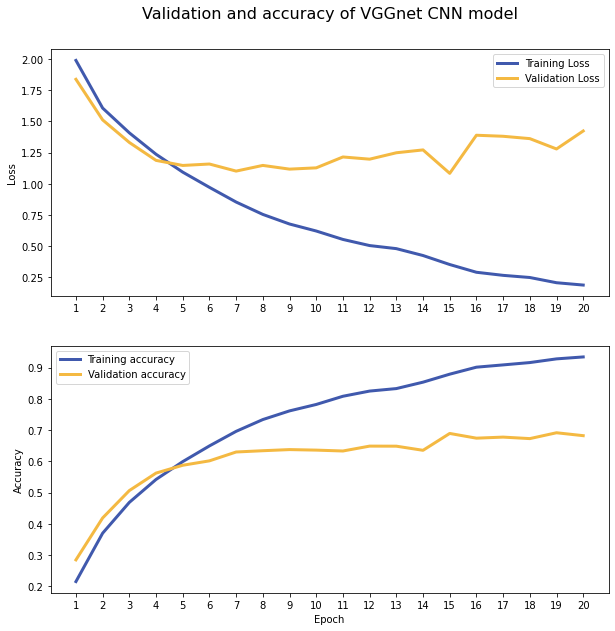

In [ ]:
plot_loss_accuracy(vggnet_history, 'Validation and accuracy of VGGnet CNN model')

# Compare the model performance

In [ ]:
def plot_comparison_line():
  """
  Plots four graphs to display the validation accuracy, training accuracy,
  validation loss and training loss of 3 CNN models.
  """
  epoch_ticks = np.arange(0, len(mycnn_history.history['accuracy']), 1)
  epoch_labels = list()
  for label in range(len(epoch_ticks)):
    epoch_labels.append(str(label+1))


  comparison, axs = plt.subplots(2, 2, figsize=(18,12))

  # plot training loss comparison graph
  plt.sca(axs[0,0])
  axs[0,0].plot(mycnn_history.history['loss'],color='#4059AD',label='My CNN',
                linewidth=3)
  axs[0,0].plot(lenet_history.history['loss'],color='#97D8C4',label='LeNet',
                linewidth=3)
  axs[0,0].plot(vggnet_history.history['loss'],color='#F4B942',label='VGGNet',
                linewidth=3)

  # change graph parameters
  plt.legend(frameon=False)
  plt.title('Training loss')
  plt.xticks(epoch_ticks, labels=epoch_labels, alpha=0.7)
  plt.yticks(alpha=0.7)
  plt.gca().spines["top"].set_alpha(0.0)
  plt.gca().spines["bottom"].set_alpha(0.3)
  plt.gca().spines["right"].set_alpha(0.0)
  plt.gca().spines["left"].set_alpha(0.3)
  plt.gca().grid(axis='both', alpha=.1, linewidth=.7, color='black',
                 linestyle='dashed')
  plt.gca().set_xlabel("Epoch", style='italic')
  plt.gca().set_ylabel("Training loss", style='italic')
  plt.gca().tick_params(axis="y", left=False)
  plt.gca().tick_params(axis="x", bottom=False)

  # plot validation loss comparison graph
  plt.sca(axs[0,1])
  axs[0,1].plot(mycnn_history.history['val_loss'],color='#4059AD',
                label='My CNN', linewidth=3)
  axs[0,1].plot(lenet_history.history['val_loss'],color='#97D8C4',
                label='LeNet', linewidth=3)
  axs[0,1].plot(vggnet_history.history['val_loss'],color='#F4B942',
                label='VGGNet', linewidth=3)

  # change graph parameters
  plt.legend(frameon=False)
  plt.title('Validation loss')
  plt.xticks(epoch_ticks, labels=epoch_labels, alpha=0.7)
  plt.yticks(alpha=0.7)
  plt.gca().spines["top"].set_alpha(0.0)
  plt.gca().spines["bottom"].set_alpha(0.3)
  plt.gca().spines["right"].set_alpha(0.0)
  plt.gca().spines["left"].set_alpha(0.3)
  plt.gca().grid(axis='both', alpha=.1, linewidth=.7, color='black',
                 linestyle='dashed')
  plt.gca().set_ylabel("Validation loss", style='italic')
  plt.gca().set_xlabel("Epoch", style='italic')
  plt.gca().tick_params(axis="y", left=False)
  plt.gca().tick_params(axis="x", bottom=False)

  # plot training accuracy comparison graph
  plt.sca(axs[1,0])
  axs[1,0].plot(mycnn_history.history['accuracy'],color='#4059AD',
                label='My CNN', linewidth=3)
  axs[1,0].plot(lenet_history.history['accuracy'],color='#97D8C4',label='LeNet', linewidth=3)
  axs[1,0].plot(vggnet_history.history['accuracy'],color='#F4B942',label='VGGNet', linewidth=3)

  # change graph parameters
  plt.legend(frameon=False)
  plt.title('Training accuracy')
  plt.xticks(epoch_ticks, labels=epoch_labels, alpha=0.7)
  plt.yticks(alpha=0.7)
  plt.gca().spines["top"].set_alpha(0.0)
  plt.gca().spines["bottom"].set_alpha(0.3)
  plt.gca().spines["right"].set_alpha(0.0)
  plt.gca().spines["left"].set_alpha(0.3)
  plt.gca().grid(axis='both', alpha=.1, linewidth=.7, color='black',
                 linestyle='dashed')
  plt.gca().set_ylabel("Training accuracy", style='italic')
  plt.gca().set_xlabel("Epoch", style='italic')
  plt.gca().tick_params(axis="y", left=False)
  plt.gca().tick_params(axis="x", bottom=False)

  # plot validation accuracy comparison graph
  plt.sca(axs[1,1])
  axs[1,1].plot(mycnn_history.history['val_accuracy'],color='#4059AD',
                label='My CNN', linewidth=3)
  axs[1,1].plot(lenet_history.history['val_accuracy'],color='#97D8C4',
                label='LeNet', linewidth=3)
  axs[1,1].plot(vggnet_history.history['val_accuracy'],color='#F4B942',
                label='VGGNet', linewidth=3)

  # change graph parameters
  plt.legend(frameon=False)
  plt.title('Validation accuracy')
  plt.xticks(epoch_ticks, labels=epoch_labels, alpha=0.7)
  plt.yticks(alpha=0.7)
  plt.gca().spines["top"].set_alpha(0.0)
  plt.gca().spines["bottom"].set_alpha(0.3)
  plt.gca().spines["right"].set_alpha(0.0)
  plt.gca().spines["left"].set_alpha(0.3)
  plt.gca().grid(axis='both', alpha=.1, linewidth=.7, color='black',
                 linestyle='dashed')
  plt.gca().set_ylabel("Validation accuracy", style='italic')
  plt.gca().set_xlabel("Epoch", style='italic')
  plt.gca().tick_params(axis="y", left=False)
  plt.gca().tick_params(axis="x", bottom=False)


  comparison.suptitle("Comparison of performance between different CNN models", fontsize=20)

In [ ]:
def plot_comparison_bar():
  """
  Produces a bar chart showing the best values of various performance metrics across different CNN models
  """
  comparison_df = pd.DataFrame(columns=['CNN', 'Metric', 'Value'])
  model_list = [mycnn_history, lenet_history, vggnet_history]
  model_name_list = ['My CNN', 'LeNet', 'VGGNet']
  metric_list = ['val_accuracy', 'accuracy', 'val_loss', 'loss']

  for model in range(len(model_list)):
    for metric in metric_list:
      if metric == 'val_accuracy' or metric == 'accuracy':
        comparison_df = comparison_df.append({
        'CNN': model_name_list[model],
        'Metric':metric,
        'Value': max(model_list[model].history[metric])
        }, ignore_index=True)
      else:
        comparison_df = comparison_df.append({
        'CNN': model_name_list[model],
        'Metric':metric,
        'Value': min(model_list[model].history[metric])
        }, ignore_index=True)

  bar_fig, ax = plt.subplots(1,1,figsize=(10,7))
  plt.sca(ax)

  colours=['#4059AD', '#97D8C4', '#F4B942']
  sns.barplot(data=comparison_df,
              x='Metric',
              y='Value',
              hue='CNN',
              palette=colours,
              zorder=10
              )
  plt.gca().set_xticklabels(labels=['Validation accuracy',
                                    'Training accuracy',
                                    'Validation loss',
                                    'Training loss'
                                    ])

  plt.legend(frameon=False, fontsize=12)

  plt.title('Best values of various performance metrics,'
            '\nacross different CNN models', fontsize=15)
  plt.xticks(alpha=0.7)
  plt.yticks(alpha=0.7)
  plt.gca().spines["top"].set_alpha(0.0)
  plt.gca().spines["bottom"].set_alpha(0.3)
  plt.gca().spines["right"].set_alpha(0.0)
  plt.gca().spines["left"].set_alpha(0.3)
  plt.gca().grid(axis='y', alpha=.1, linewidth=.7, color='black',
                 linestyle='dashed')
  plt.gca().set_ylabel("Value", style='italic')
  plt.gca().set_xlabel("Performance metric", style='italic')
  plt.gca().tick_params(axis="y", left=False)
  plt.gca().tick_params(axis="x", bottom=False)

  plt.plot()

In [ ]:
def plot_confusion_matrices(X_test, y_test):
  """
  Produces a confusion matrix for each CNN that needs to be compared
  """
  # get class names
  class_names = get_class_names()

  # normalise image pixels between 0 and 1
  X_test = X_test.astype('float32') / 255.0

  cnn_models = [my_cnn, VGG_net, le_net]
  cnn_models_names = ['my CNN', 'VGGNet CNN', 'LeNet CNN']
  confusion_matrices = list()

  fig = plt.figure(figsize=(32,8))

  # loop through the cnn models, creating a confusion matrix for each
  for model in range(len(cnn_models)):
    fig.add_subplot(1, 3, (1+model))
    y_pred = cnn_models[model].predict(X_test)
    y_pred_1d = list()
    for x in range(len(y_pred)):
      y_pred_1d.append(int(np.where(y_pred[x] == y_pred[x].max())[0]))

    confusion_matrices.append(metrics.confusion_matrix(y_test, y_pred_1d))
    sns.heatmap(confusion_matrices[model],
            cmap='coolwarm',
            annot=True,
            vmax=600,
            fmt='.3g')
    plt.gca().set_xticklabels(class_names)
    plt.gca().set_yticklabels(class_names)
    plt.gca().tick_params(axis='both', rotation=45)
    plt.title('Confusion matrix for {0} model'.format(cnn_models_names[model]),
              fontsize=16
              )
    plt.xlabel('Predicted label', fontsize=13)
    plt.ylabel('Actual label', fontsize=13)

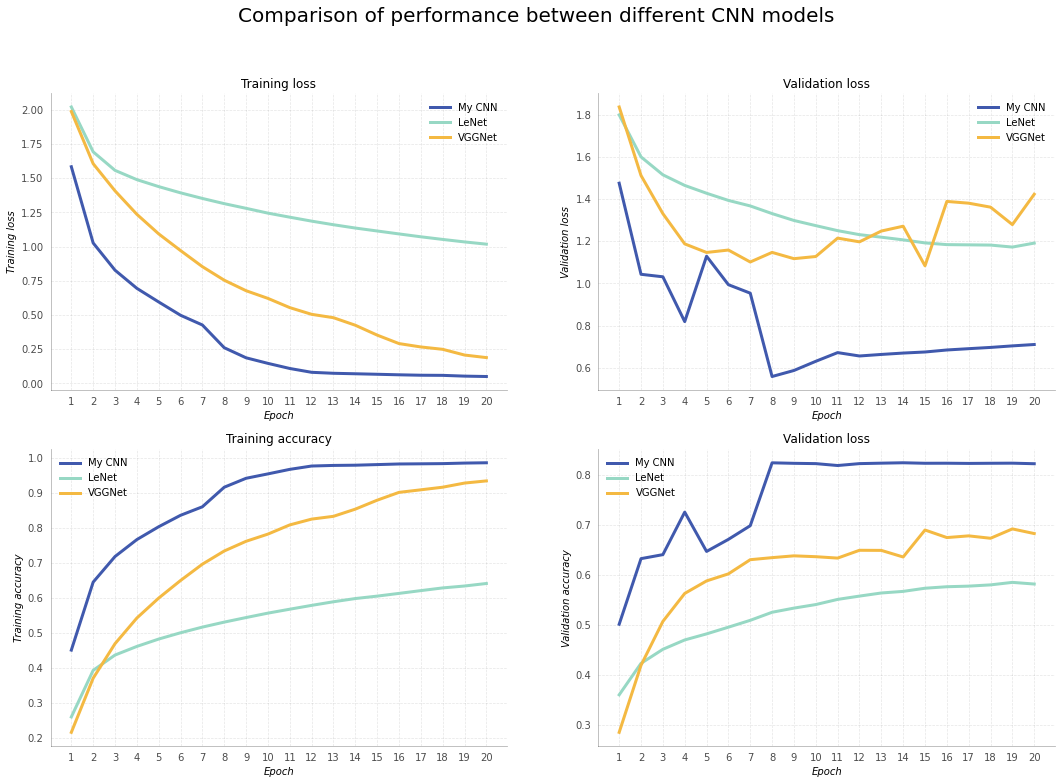

In [ ]:
plot_comparison_line()

1
1
2
2
1
1
2
2
1
1
2
2


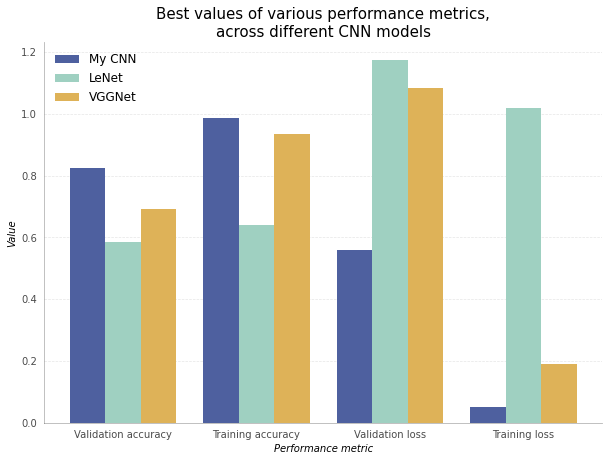

In [ ]:
plot_comparison_bar()

313/313 [==============================] - 1s 3ms/step


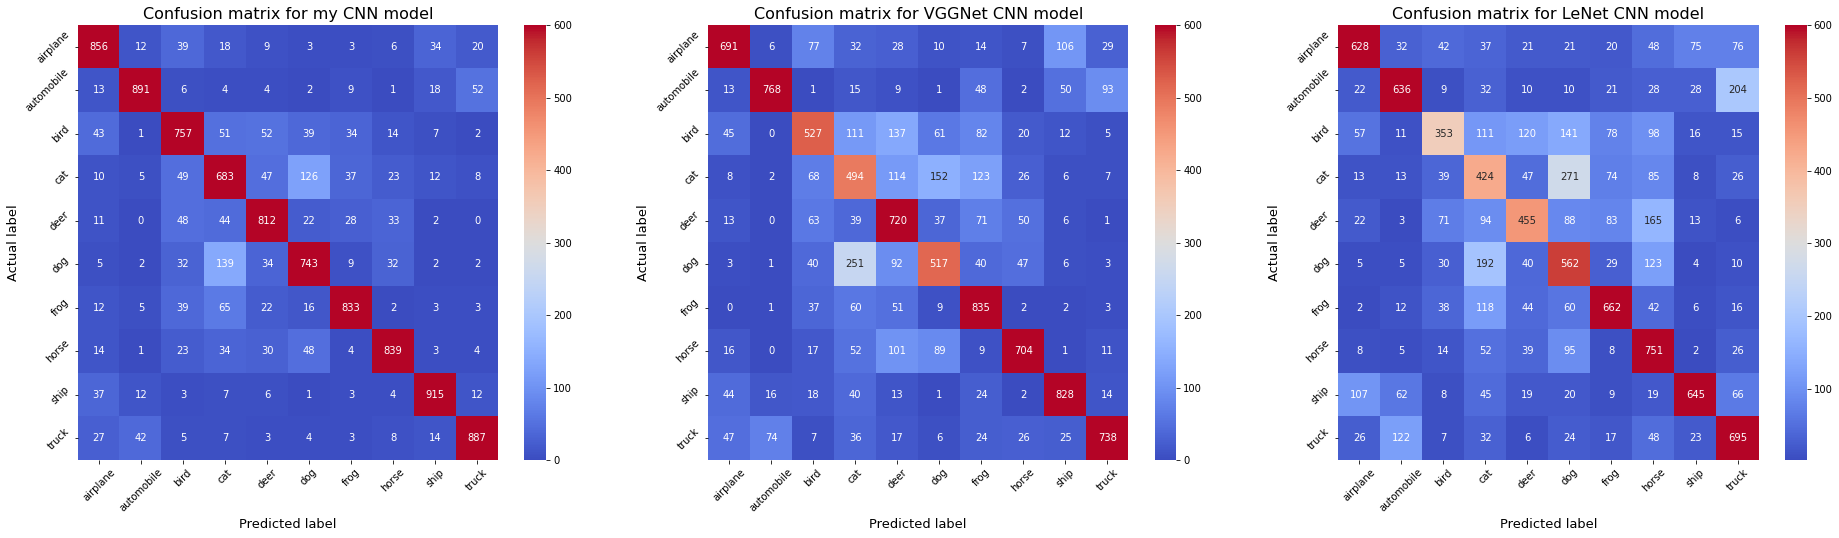

In [ ]:
plot_confusion_matrices(X_test, y_test)